In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import math
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import easydict
from pathlib import Path

from ltsf.model import build
from ltsf.datasets import dataset
import ltsf.metric as metric
from ltsf import util
from ltsf.metric import CorrelationSkill, AverageMeter
import easydict
import csv
import pandas as pd
import tqdm

from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
def valid(args, model, valset, criterion):
    testloader = tqdm.tqdm(DataLoader(valset, batch_size=1, shuffle=False, drop_last=False), total=len(valset))
    valloss = AverageMeter()
    model.eval()

    assemble_real_nino = np.zeros((len(valset), 23))
    assemble_pred_nino = np.zeros((len(valset), 23))

    with torch.no_grad() :
        for i, (src, label) in enumerate(testloader):
            src = src.clone().detach().requires_grad_(True).to(device=device)
            # tgt = torch.zeros_like(tgt).clone().detach().requires_grad_(True).to(device=device)
            label = label.clone().detach().requires_grad_(True).to(device=device)

            idx = src.shape[0]*i
            uncertaintyarry_nino = np.zeros((1, src.shape[0], 23))

            for b in range(int(1)):
                output = model(src) # inference
                vl = val_crit(output, label)
                valloss.update(vl)
                uncertaintyarry_nino[b, :, :] = output[:,-23:].cpu()

                assemble_real_nino[idx:idx+src.shape[0], :] = label[:,-23:].cpu().numpy()

            assemble_pred_nino[idx:idx+src.shape[0], :] += np.mean(uncertaintyarry_nino, axis=0)
            
            del src
            del label

            testloader.set_description(f'loss = {valloss.avg:.4f}-{vl:.4f}')

        corr = np.zeros(23)
        for i in range(23):
            corr[i] = CorrelationSkill(assemble_real_nino[:, i], assemble_pred_nino[:, i])

        mse = mean_squared_error(assemble_pred_nino, assemble_real_nino)
        print(corr)

        util.ploter(corr, f'{Folder}/fig/{args.current_epoch}.png')

    return assemble_pred_nino, assemble_real_nino


def plotresult(fp, num, args, model, valset, criterion):
    dd = '/eval_' + num
    os.makedirs(str(Folder) + dd, exist_ok=True)

    assemble_pred_nino, assemble_real_nino = valid(args, model, valset, criterion)

    corr = np.zeros(23)
    for i in range(23):
        corr[i] = CorrelationSkill(assemble_real_nino[:, i], assemble_pred_nino[:, i])
        print('Save prediction: lead = {}'.format(i) )
        inputTimeSeq = assemble_real_nino.shape[0]
        dwidth = 800
        dpi = 90
        dheight = 180
        plt.figure(figsize=(dwidth/dpi, dheight/dpi))
        timeValues = np.arange(0, inputTimeSeq)
        plt.plot(timeValues, assemble_real_nino[:, i], marker='', color='blue', linewidth=1, label="Measurement")
        plt.plot(timeValues, assemble_pred_nino[:, i], marker='', color='red', linewidth=1, linestyle='dashed', label="Prediction")
        plt.savefig(str(Folder) + f"{dd}/NinoPred_" + str(i).zfill(6) + ".png", orientation='landscape', bbox_inches='tight')
        plt.show()
        plt.close()

    print(corr)

    np.savetxt(f'{Folder}{dd}/correlation.csv',corr,delimiter=",")

    # print(assemble_pred_nino)
    np.save(f"{Folder}{dd}/lead_assemble_real_nino", assemble_real_nino) # 길이가 valset인 것이 ensemble 갯수 만큼 들어있음
    np.save(f"{Folder}{dd}/lead_assemble_pred_nino", assemble_pred_nino)

    return corr

def compare(corr, fp, num, label):
    aa = fp + 'eval_' + num

    # baseline_mse, trans_mse, twodimmse, twolossmse = getmse()
    baseline, trans, twodim, twoloss, corrloss = getcorr()

    timeline = np.linspace(0, 22, 1)

    # axes = plt.axes()
    # axes.set_ylim([0,1])
    # plt.plot(timeline, np.sqrt(baseline_mse), marker='', color='blue', linewidth=1, label="baseline")
    # plt.plot(timeline, np.sqrt(trans_mse), marker='', color='red', linewidth=1, label="rfb_transformer")
    # # plt.plot(timeline, np.sqrt(twolossmse), marker='', color='green', linewidth=1, label="vit_twoloss")
    # plt.plot(timeline, np.sqrt(mse), marker='', color='purple', linewidth=1, label=label)
    # plt.legend()
 
    # plt.savefig(aa + '/mse_compare.png', orientation='landscape', bbox_inches='tight')
    # plt.show()
    # plt.close()

    # plt.cla()


    axes = plt.axes()
    axes.set_xlim([0, 23])
    axes.set_ylim([0,1])
    plt.plot(timeline, baseline, marker='', color='blue', linewidth=1, label="baseline")
    plt.plot(timeline, trans, marker='', color='red', linewidth=1, label="rfb_transformer")
    # plt.plot(timeline, np.sqrt(twoloss), marker='', color='green', linewidth=1, label="vit_twoloss")
    plt.plot(timeline, corr, marker='', color='purple', linewidth=1, label=label)
    plt.legend()

    plt.savefig(aa + '/corr_compare.png', orientation='landscape', bbox_inches='tight')
    plt.show()
    plt.close()


def getcorr():
    # twodimcnn = [0.9294535,0.91590372,0.87245369,0.81624529,0.76330807,0.71168656
    #         ,0.66971695,0.6255489,0.59937599,0.59152533,0.56929781,0.57241524
    #         ,0.56720474,0.53959906,0.53506053,0.51028036,0.48267573,0.44623802
    #         ,0.42490706,0.39693028,0.35924735,0.32473416,0.28993454]

    twodimcnn = [0.87797048,0.87023331,0.83614309,0.80246051,0.76957703,0.73951732
                ,0.71618847,0.69847897,0.68389941,0.66393678,0.64016199,0.61270817
                ,0.58159395,0.5464659,0.51856569,0.49069667,0.45057754,0.40187238
                ,0.33761924,0.27528526,0.23281086,0.1798104,0.16641316]

    baseline = [0.90375662, 0.89310532, 0.85104236, 0.80583616, 0.74700119, 0.68805024
            ,0.64004255, 0.61192831, 0.58498279, 0.56291843, 0.53021225, 0.51725378
            ,0.48547276, 0.47183246, 0.44534206, 0.43026313, 0.40954246, 0.39029018
            ,0.38272185, 0.37395304, 0.36700487, 0.35023261, 0.32886644]

    trans = [9.37E-01,9.29E-01,9.00E-01,8.67E-01,8.30E-01,7.85E-01,7.40E-01
            ,7.02E-01,6.67E-01,6.36E-01,6.01E-01,5.65E-01,5.33E-01,5.10E-01
            ,4.89E-01,4.72E-01,4.51E-01,4.34E-01,4.12E-01,3.95E-01,3.76E-01
            ,3.60E-01,3.39E-01]

    twoloss = [0.94272792 ,0.92808749 ,0.88417982 ,0.83303625, 0.77855154, 0.71762297
    ,0.66378813 ,0.62712898 ,0.59591068 ,0.57344433, 0.54992418, 0.51244391
    ,0.49698463 ,0.4959474  ,0.4946409  ,0.49071608, 0.47689809, 0.45671596
    ,0.43125589 ,0.42269416 ,0.40528805 ,0.38918046, 0.37052003]

    corrloss = [0.78085976 ,0.76601635 ,0.70474282, 0.65893893, 0.59845962, 0.56696576
                ,0.50374322 ,0.47880643 ,0.46453552, 0.45799808, 0.41300029, 0.40151784
                ,0.39061753 ,0.37610801 ,0.29728042, 0.23347832, 0.19291504, 0.18244784
                ,0.15851624 ,0.10160118 ,0.11149167, 0.11137596, 0.11123336]


    return baseline, trans, twodimcnn, twoloss, corrloss

def getmse():
    baseline_mse = [0.14245229 ,0.15176659 ,0.21113602 ,0.2803528  ,0.35378224 ,0.42568714
                ,0.48938734 ,0.53120054 ,0.56884297 ,0.59894049 ,0.62406066 ,0.64691595
                ,0.665724   ,0.685555   ,0.70628766 ,0.71863057 ,0.73469082 ,0.74410355
                ,0.75489915 ,0.75465311 ,0.75547143 ,0.75034072 ,0.74497082]



    trans_mse = [0.15202061 ,0.16552944 ,0.23341914 ,0.29851638 ,0.36664409 ,0.43075233
                ,0.47981692 ,0.50226231 ,0.52887196 ,0.55165997 ,0.58045937 ,0.60744801
                ,0.63956582 ,0.65761316 ,0.68639857 ,0.70053593 ,0.71932677 ,0.72996341
                ,0.74831092 ,0.75401899 ,0.75376829 ,0.75138524 ,0.76215806]

    # twodimcnn_mse = [0.10440155,0.12305518,0.18533027,0.26773953,0.33833587,0.40438726
    #                 ,0.45247577,0.50099879,0.52999656,0.54508839,0.57087975,0.57319739
    #                 ,0.58352541,0.60487012,0.60630755,0.62621512,0.6505984,0.68400098
    #                 ,0.70633535,0.73157495,0.75466525,0.77619356,0.79621094]

    twodimcnn_mse = [0.26267617,0.20164667,0.25757204,0.32053927,0.39002035,0.43877803
                    ,0.45900149,0.47882055,0.49832767,0.52270331,0.54337768,0.57269402
                    ,0.60194564,0.63117916,0.64668539,0.66478106,0.70156517,0.73569109
                    ,0.77526975,0.80955846,0.82480109,0.84073801,0.84677622]


    twoloss_mse = [0.1038604  ,0.12485667 ,0.19513106 ,0.29182439, 0.36944173, 0.43874408
    ,0.48725133 ,0.51639513 ,0.54440538 ,0.56261593, 0.58601967, 0.62211701
    ,0.63189618 ,0.62910985 ,0.63067247 ,0.63401239, 0.64879604, 0.67467751
    ,0.71918714 ,0.71807392 ,0.73776863 ,0.7480545,  0.76219895]



    return baseline_mse, trans_mse, twodimcnn_mse, twoloss_mse

Current cuda device  1


loss = 1.2317-0.5214: 100%|██████████| 456/456 [00:15<00:00, 29.02it/s]


[ 0.14213362  0.12887899 -0.16087883 -0.10397887 -0.0949057   0.03525601
 -0.17924453  0.17628057 -0.14565113  0.12071641 -0.11962809  0.06013022
 -0.19461064 -0.25413539 -0.2053614  -0.05120955 -0.24966292 -0.21174224
 -0.16183576  0.14794971 -0.05710516 -0.19519392 -0.02985451]
Save prediction: lead = 0


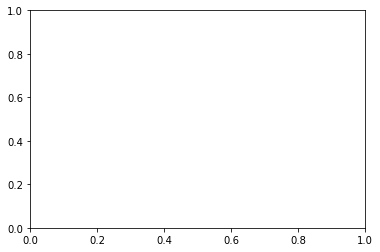

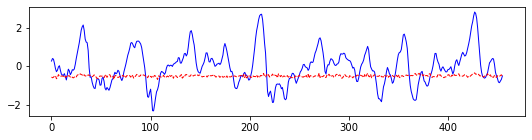

Save prediction: lead = 1


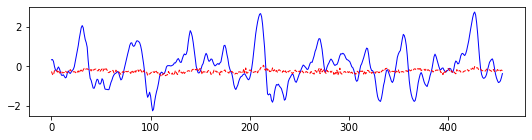

Save prediction: lead = 2


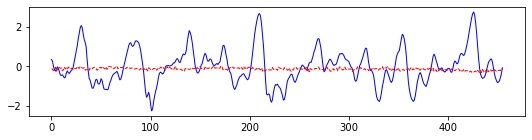

Save prediction: lead = 3


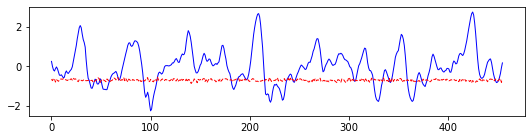

Save prediction: lead = 4


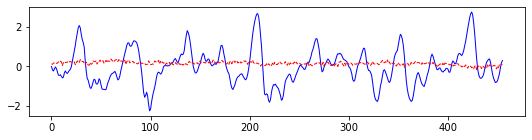

Save prediction: lead = 5


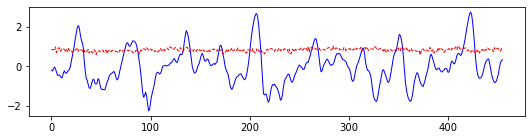

Save prediction: lead = 6


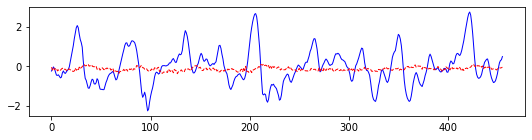

Save prediction: lead = 7


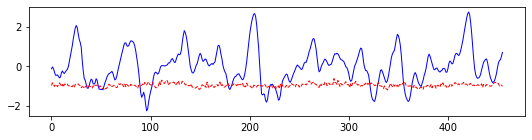

Save prediction: lead = 8


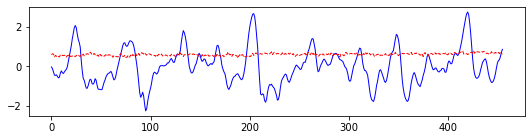

Save prediction: lead = 9


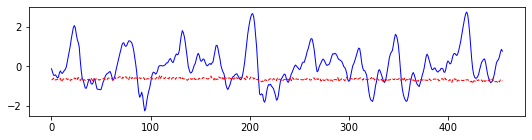

Save prediction: lead = 10


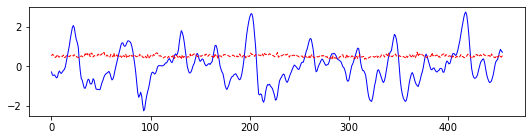

Save prediction: lead = 11


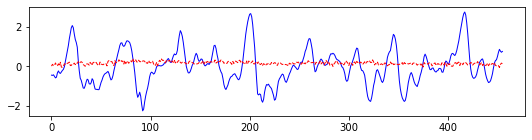

Save prediction: lead = 12


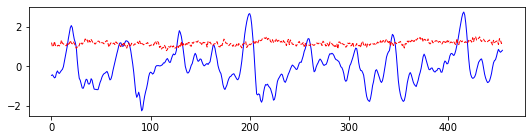

Save prediction: lead = 13


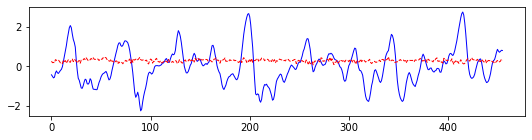

Save prediction: lead = 14


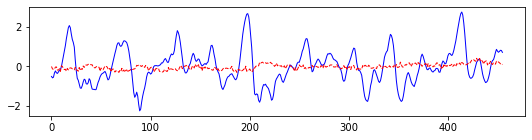

Save prediction: lead = 15


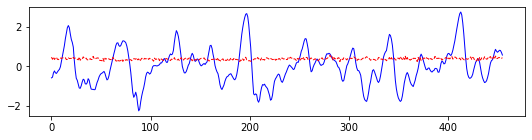

Save prediction: lead = 16


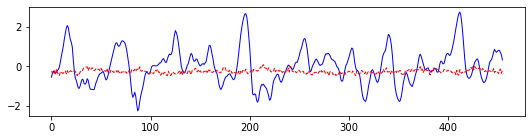

Save prediction: lead = 17


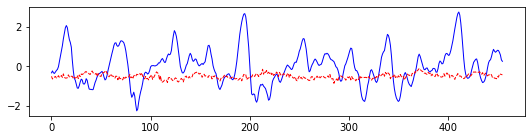

Save prediction: lead = 18


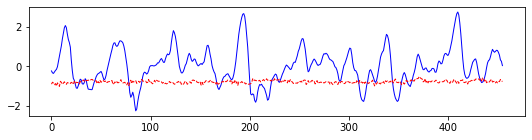

Save prediction: lead = 19


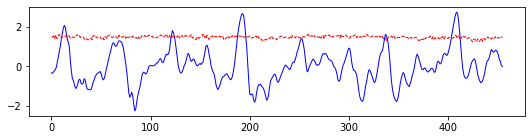

Save prediction: lead = 20


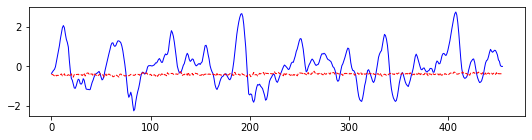

Save prediction: lead = 21


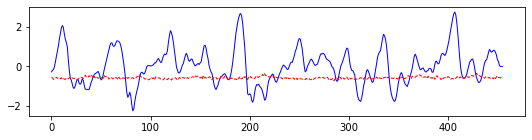

Save prediction: lead = 22


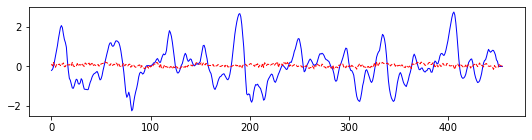

No handles with labels found to put in legend.


[ 0.14213362  0.12887899 -0.16087883 -0.10397887 -0.0949057   0.03525601
 -0.17924453  0.17628057 -0.14565113  0.12071641 -0.11962809  0.06013022
 -0.19461064 -0.25413539 -0.2053614  -0.05120955 -0.24966292 -0.21174224
 -0.16183576  0.14794971 -0.05710516 -0.19519392 -0.02985451]


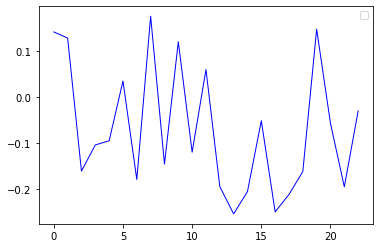

In [3]:
args = easydict.EasyDict({'gpu' : 1,
'name' : 'test',
'current_epoch' : 0,
'data' : 0,
'model' : 'encoders',
'dataset' : 'basicdataset'})

GPU_NUM = args.gpu
device = torch.device('cuda:{}'.format(GPU_NUM) if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) 
print ('Current cuda device ', torch.cuda.current_device()) 

args.valloss_best = 0

Folder = Path(str(Path('.').parent) + "/local/" + args.name)
os.makedirs(f'{Folder}/fig/', exist_ok=True)
dataFolder = Path(str(Path('.').parent) + '/local/Dataset/') 

model = build.__dict__[args.model]().to(device=device)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005, alpha=0.9)
optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.MSELoss(reduction='mean')
criterion = metric.weightedMSE()
val_crit = nn.MSELoss()


if args.data == 1:
    SSTFile_train_sst = dataFolder / 'oisst' / 'finetuning' / 'sst.nc'
    SSTFile_train_hc = dataFolder / 'oisst' / 'finetuning' / 'hc.nc'
    SSTFile_test_sst = dataFolder / 'oisst' / 'test' / 'sst.nc'
    SSTFile_test_hc = dataFolder / 'oisst' / 'test' / 'hc.nc'

    trainset = dataset.__dict__[args.dataset](SSTFile_train_sst, SSTFile_train_hc, 'train')
    valset = dataset.__dict__[args.dataset](SSTFile_test_sst, SSTFile_test_hc, 'valid')
elif args.data == 2:
    SSTFile_train = dataFolder / 'Ham' / 'cmip5_tr.input.1861_2001.nc'
    SSTFile_train_label = dataFolder / 'Ham' / 'cmip5_tr.label.1861_2001_integrated.npy'
    SSTFile_val = dataFolder / 'Ham' / 'godas.input.1980_2017.nc'
    SSTFile_val_label = dataFolder / 'Ham' / 'godas.label.1980_2017_integrated.npy'

    trainset = dataset.__dict__[args.dataset](SSTFile_train, SSTFile_train_label, sstName='sst', hcName='t300', labelName='pr', currnet_epoch = args.current_epoch)  #datasets_general_3D_alllead_add(SSTFile_train, SSTFile_train_label, SSTFile_train2, SSTFile_train_label2, lead, sstName='sst', hcName='t300', labelName='pr', noise = True) 
    valset = dataset.__dict__[args.dataset](SSTFile_val, SSTFile_val_label, sstName='sst', hcName='t300', labelName='pr')
elif args.data == 0:
    SSTFile_train = dataFolder / 'Ham' / 'cmip5_tr.input.1861_2001.nc'
    SSTFile_train_label = dataFolder / 'Ham' / 'cmip5_tr.label.1861_2001.nc'
    SSTFile_val = dataFolder / 'Ham' / 'godas.input.1980_2017.nc'
    SSTFile_val_label = dataFolder / 'Ham' / 'godas.label.1980_2017.nc'

    trainset = dataset.__dict__[args.dataset](SSTFile_train, SSTFile_train_label, sstName='sst', hcName='t300', labelName='pr')  #datasets_general_3D_alllead_add(SSTFile_train, SSTFile_train_label, SSTFile_train2, SSTFile_train_label2, lead, sstName='sst', hcName='t300', labelName='pr', noise = True) 
    valset = dataset.__dict__[args.dataset](SSTFile_val, SSTFile_val_label, sstName='sst', hcName='t300', labelName='pr')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

fp, num = "local/encoder/", '7'
corr = plotresult(fp, num, args, model=model, valset=valset, criterion=criterion)

plt.plot(corr, marker='', color='blue', linewidth=1, label="")
plt.legend()
plt.savefig('cc.png', orientation='landscape', bbox_inches='tight')

plt.show()
plt.close()
